# Bengali.AI - Training loop

The notebook was created in Kaggle. It only contains the code for the training loop, and the (preprocessed) data still has  to be put into a `Dataset` object (see below) to initialize the train/test datasets and loaders. After this is done, the training loop should work but I have only tested it as far as possible with a (simpler) placeholder dataset. Some parts do not have a defined output yet (e.g., model output), thus a certain output format is assumed for now in those cases.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import recall_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
train_images = np.load('train_image_data.npy')

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
        super(ResidualBlock, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x


class ResNet34(nn.Module):
    """
    from 'ResNet-34 PyTorch Starter Kit'
    """

    def __init__(self):
        super(ResNet34, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.block2 = nn.Sequential(
            nn.MaxPool2d(1, 1),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64, 2)
        )

        self.block3 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128, 2)
        )

        self.block4 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256, 2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256, 512),
            ResidualBlock(512, 512, 2)
        )

        self.avgpool = nn.AvgPool2d(2)
        # grapheme_root
        self.fc1 = nn.Linear(2048, 168)
        # vowel_diacritic
        self.fc2 = nn.Linear(2048, 11)
        # consonant_diacritic
        self.fc3 = nn.Linear(2048, 7)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1, x2, x3

In [4]:
train_labels = pd.read_csv('train.csv')
train_labels.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


TODO: split dataset into train and validation set.

In [5]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet34() # initialize model here
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
# Put data into Dataset object
class BengaliDataset(Dataset):
    def __init__(self, images, labels, device):
        super(Dataset, self).__init__()
        self.images = images
        
        self.labels = labels.iloc[:, 1:-1].to_numpy()
        self.labels = torch.tensor(self.labels).to(device)
        
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        img = img.to(self.device).unsqueeze(0)
        img = (img - 18.199728) / 52.948593
        
        labels = tuple(self.labels[idx])

        return (img,) + labels       

In [17]:
BATCH_SIZE = 128
train_dataset = BengaliDataset(train_images, train_labels, device) # alternatively use TensorDataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # num_workers can be set
# TODO: test_dataset and test_loader (=validation set)

In [18]:
def eval_metric(pred_dict, true_dict):
    """
    Competition evaluation metric adapted from:
    https://www.kaggle.com/c/bengaliai-cv19/overview/evaluation
    The metric describes the weighted average of component 
    macro-averaged recalls.
    
    Args:
        pred_dict = [dict] dictionary with components as keys and
                           lists of predictions as values
        true_dict = [dict] dictionary with components as key and
                           lists of targets as values
    
    Returns [float]:
        Weighted average of component macro-averaged recalls
    """
    scores = []
    for key in ['grapheme', 'vowel', 'consonant']:
        score = recall_score(true_dict[key], pred_dict[key], average='macro')
        scores.append(score)
    return np.average(scores, weights=[2, 1, 1])

In [19]:
def update_dicts(key, pred_dict, true_dict, pred, target):
    """
    Updates two dictionaries given a key with the provided values.
    Assumes batches.
    
    Args:
        key       = [string] the key in the dictionary to update
        pred_dict = [dict] dictionary with components as keys and
                           lists of predictions as values
        true_dict = [dict] dictionary with components as key and
                           lists of targets as values
        pred      = [torch.Tensor] tensor of (raw) predictions
        target    = [torch.Tensor] tensor of targets
    """
    _, pred = torch.max(pred.data, 1)
    pred_list = pred.tolist()
    target_list = target.tolist()
    pred_dict[key] += pred_list
    true_dict[key] += target_list

Naming convention:
- `x` = input
- `t` = target
- `y` = predicted output


In [20]:
def train(model, train_loader, optimizer, criterion, epochs=10, PATH=None):
    losses = [] # keep track of losses
    scores = [] # keep track of scores
    
    for epoch in range(epochs):
        running_loss = 0.0
        pred_dict = {'grapheme': [], 'vowel': [], 'consonant': []}
        true_dict = {'grapheme': [], 'vowel': [], 'consonant': []}
        
        for i, data in enumerate( tqdm(train_loader, desc=f"Epoch {epoch+1}") ):
            # unpack input and targets
            x, t_graph, t_vowel, t_conso = data # depends on what is returned by Dataset.__getitem__
            
            # predict
            optimizer.zero_grad()            
            y_graph, y_vowel, y_conso = model(x) # depends on what is returned by the model.forward()
            
            # loss
            loss_graph = criterion(y_graph, t_graph)
            loss_vowel = criterion(y_vowel, t_vowel)
            loss_conso = criterion(y_conso, t_conso)
            loss = loss_graph + loss_vowel + loss_conso # maybe tailor loss to evaluation metric
            loss.backward()
            optimizer.step()            
            running_loss += loss.item()
            
            # update pred_dict and true_dict
            update_dicts('grapheme', pred_dict, true_dict, y_graph, t_graph)
            update_dicts('vowel', pred_dict, true_dict, y_vowel, t_vowel)
            update_dicts('consonant', pred_dict, true_dict, y_conso, t_conso)
        
        losses.append(running_loss / len(train_loader))
        score = eval_metric(pred_dict, true_dict)
        scores.append( score )
        
        print('Loss: {:.3f}'.format( running_loss / len(train_loader) ))
        print('Score: {:.3f}'.format( score ))
        
    # save model weights if PATH is provided
    if PATH:
        torch.save(model.state_dict(), PATH)
    return losses, scores            

In [21]:
losses, scores = train(model, train_loader, optimizer, criterion, epochs=2)
torch.save(model.state_dict(), 'model.pt')

tensor([ 44,  95, 124,  71,  85,  48,  13, 141,  59, 133, 139,  17,  55, 123,
         96, 124,   2,  56,  54, 147,  90, 159, 149, 107,  79,  85,  54,  48,
         96,  83,  96,  98,  69, 107,  57, 153, 163, 151, 115, 122, 142,  24,
         45, 143, 153,  77,  50,  22, 118,  14,  81,  93, 139,  38,  64, 114,
         23,  85,  36, 153, 121, 133, 107,  23, 107, 123,  72, 137,  98,  23,
         36,  53, 119,  43,  36, 100, 117, 146, 157, 127, 147,  38,  81,  95,
        119, 107,  16,  38, 115, 147,  94,  96,  53, 132,  86, 115,  85,  79,
         96,  38,  57,  71,  43,  79, 145, 103, 122,  43,  72,  28,  85,  96,
         74,  88, 155,  56, 116,  38,  92, 167, 106,  25, 139, 115,  79, 107,
         77,  13])
tensor([113,  53,  22,  42, 135,  74,  64,  96,  81,  50,  39, 156, 149, 112,
        133, 153, 139, 107, 132, 118,  40, 101, 135, 150, 122, 117,  58, 149,
         16,  72, 159,  59,  53,  23,  68,  15,  42, 159, 101,  82, 117,  72,
         83,  21,  29,  85, 122, 113,   8, 13

KeyboardInterrupt: 

In [52]:
def plot_perf(losses, scores):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(losses)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss over epochs', size=14)
    ax[1].plot(scores)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Score')
    ax[1].set_title('Score over epochs', size=14)
    plt.show()

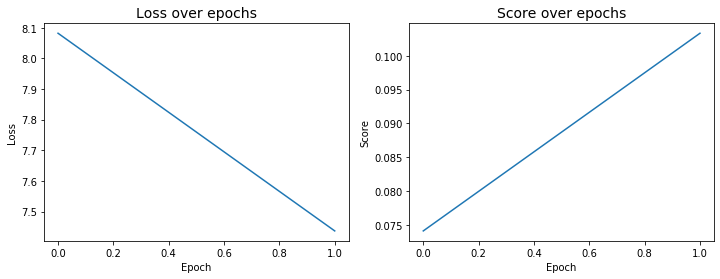

In [53]:
plot_perf(losses, scores)